This work is based on

- https://scikit-image.org/skimage-tutorials/lectures/1_image_filters.html
- https://scikit-image.org/docs/dev/auto_examples/applications/plot_rank_filters.html

# Setup

In [1]:
import warnings
import numpy as np
import cv2

from typing import Tuple
from scipy.signal import convolve2d
from skimage import data, filters
from skimage.morphology import disk, erosion, dilation
from skimage import exposure

from utils import plot, implot, apply, im_hist_plot

warnings.simplefilter("ignore")

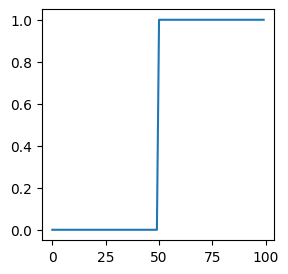

In [2]:
signal = np.zeros(100) + np.repeat(np.array([0, 1]), 50)
plot(signal)

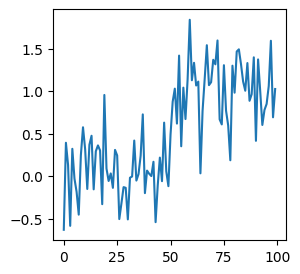

In [3]:
noisy_signal = signal + np.random.normal(0, 0.35, signal.shape)
plot(noisy_signal)

# Intuition on simple 1D signal

### Median filter
Easiest filtering method - taking mean of each 2 pixels

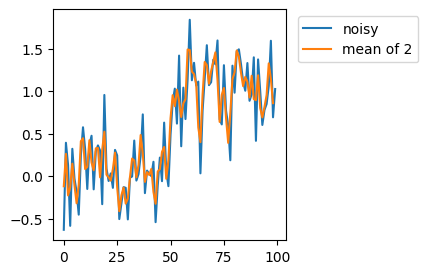

In [4]:
signal_filtered_mean2 = (noisy_signal[:-1] + noisy_signal[1:]) / 2
plot([noisy_signal, signal_filtered_mean2], ["noisy", "mean of 2"])

### Convlution

In [5]:
# convolution from scratch implementation for 1D array
def convolve(arr: np.array, kernel: np.array, mode: str = "valid") -> np.array:
    assert (
        len(arr.shape) == 1 and len(kernel.shape) == 1
    ), "Only 1D arrays are supported"
    assert kernel.shape[0] % 2 == 1, "Kernel size must be odd"
    n = kernel.shape[0]
    pad = n // 2
    kernel = kernel[::-1].reshape(-1, 1)

    if mode == "valid":
        r = np.empty(arr.shape[0] - 2 * pad)
        for i in range(pad, arr.shape[0] - pad):
            r[i - pad] = arr[i - pad : i + pad + 1].dot(kernel)

    # note it can be just implemented via adding pad and than calling convolve with "valid"
    elif mode == "same":
        padded_arr = np.zeros(arr.shape[0] + 2 * pad)
        padded_arr[pad : arr.shape[0] + pad] = arr
        r = np.empty(arr.shape[0])
        for i in range(pad, arr.shape[0] + pad):
            r[i - pad] = padded_arr[i - pad : i + pad + 1].dot(kernel)

    return r

Taking mean of larger neighborhood

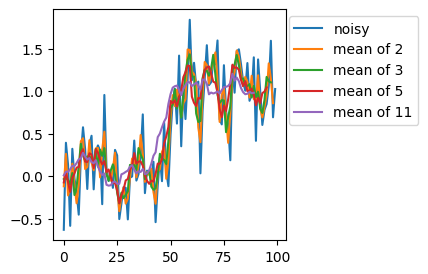

In [6]:
signal_filtered_mean3 = convolve(noisy_signal, np.ones(3) / 3)
signal_filtered_mean5 = convolve(noisy_signal, np.ones(5) / 5)
signal_filtered_mean11 = convolve(noisy_signal, np.ones(11) / 11)

plot(
    [
        noisy_signal,
        signal_filtered_mean2,
        signal_filtered_mean3,
        signal_filtered_mean5,
        signal_filtered_mean11,
    ],
    ["noisy", "mean of 2", "mean of 3", "mean of 5", "mean of 11"],
)

In [7]:
# we can accomplish it easier with numpy
np.sum(
    np.convolve(noisy_signal, np.ones(11) / 11, mode="valid") - signal_filtered_mean11
)

-5.585809592645319e-16

To avoid shortening the result we can pad it with 0s however this artificaly curves edges of our range towards 0

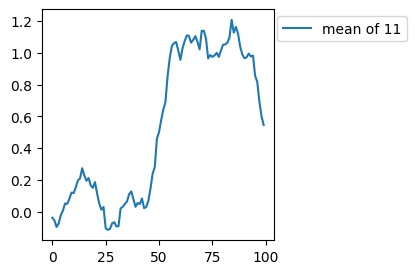

In [8]:
signal_filtered_mean11 = convolve(noisy_signal, np.ones(11) / 11, mode="same")
plot(signal_filtered_mean11, ["mean of 11"])

In [9]:
np.sum(
    np.convolve(noisy_signal, np.ones(11) / 11, mode="same") - signal_filtered_mean11
)

-5.447031714567174e-16

### Same vs valid padding

clearly valid does not cover all range and same goes to 0 near the edges

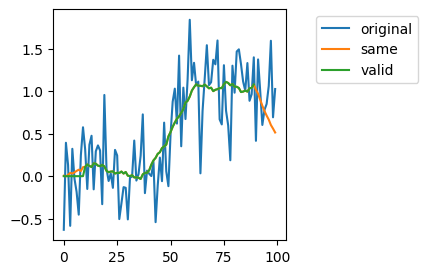

In [10]:
plot(
    [
        noisy_signal,
        convolve(noisy_signal, np.ones(21) / 21, mode="same"),
        # we add 0s to front to plot it in correct place
        np.concatenate(
            [np.zeros(10), convolve(noisy_signal, np.ones(21) / 21, mode="valid")]
        ),
    ],
    ["original", "same", "valid"],
)

### Other array extending techniques

There are another options for extending the array, but numpy wraps them 
into one parameter "full" and we cannot decide what to use. They go as follows ([link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html)):
- reflect: [a, b, c, d] -> [d, c, b, a | a, b, c, d | d, c, b, a]
- constant: [a, b, c, d] -> [k, k, k, k | a, b, c, d | k, k, k, k]
- nearest: [a, b, c, d] -> [a, a, a, a | a, b, b, c | d, d, d, d]
- mirror: [a, b, c, d] -> [d, c, b | a, b, c, d | d, c, b]
- wrap: [a, b, c, d] -> [a, b, c, d | a, b, c, d | a, b, c, d]

### [Short break for statistics](./correlations.ipynb)

### Change filters

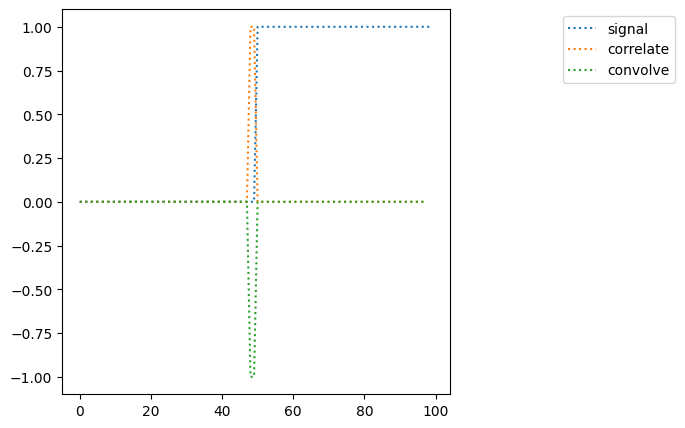

In [11]:
plot(
    [
        signal,
        np.correlate(signal, np.array([-1, 0, 1]), "valid"),
        # np.convolve(signal, np.array([-1, 0, 1]), "valid")s
        convolve(signal, np.array([-1, 0, 1]), "valid"),
    ],
    ["signal", "correlate", "convolve"],
    figsize=(5, 5),
    linestyle="dotted",
)

Here it doesn't look to informative (but it doesn't mean this filter is entirely useless)

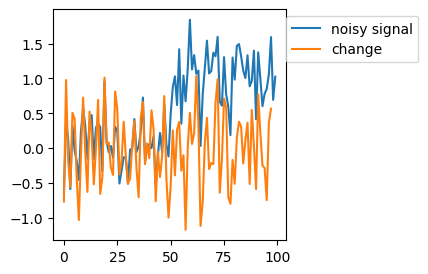

In [12]:
plot(
    [noisy_signal, np.convolve(noisy_signal, np.array([-1, 0, 1]), "valid")],
    ["noisy signal", "change"],
)

Let's try to combine both tactics - smooth a little bit change with median filter

[ 0.33333333  0.33333333  0.         -0.33333333 -0.33333333]


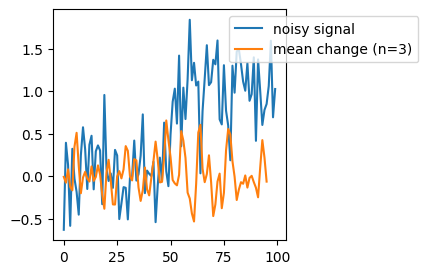

In [13]:
kernel = np.correlate(np.ones(3) / 3, [-1, 0, 1], "full")
print(kernel)

plot(
    [noisy_signal, np.convolve(noisy_signal, kernel, "valid")],
    ["noisy signal", "mean change (n=3)"],
)

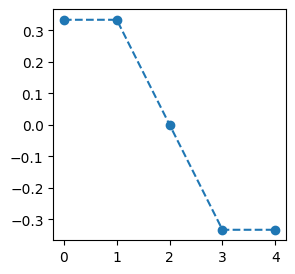

In [14]:
plot(kernel, marker="o", linestyle="--")

### Gaussian filter

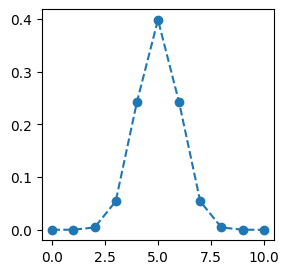

In [15]:
size = 11
center = 5
sigma = 1.0

kernel = np.arange(size)
kernel = np.exp(-((kernel - center) ** 2) / (2 * sigma**2))
kernel = kernel / (np.sqrt(2 * np.pi) * sigma)

plot(kernel, marker="o", linestyle="--")

### Combinations of gaussian, change and mean fulter

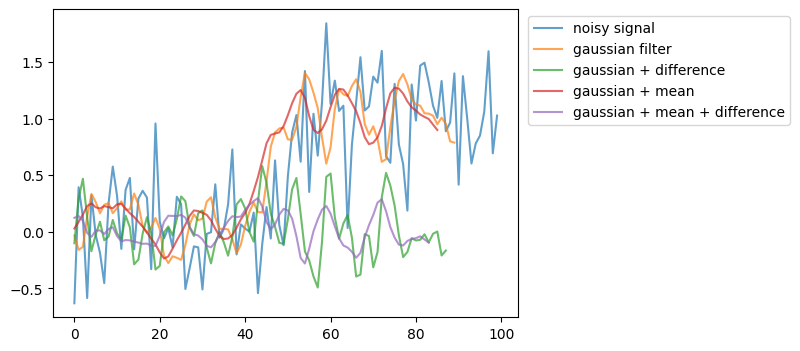

In [16]:
plot(
    [
        noisy_signal,
        np.convolve(noisy_signal, kernel, "valid"),
        np.convolve(noisy_signal, np.correlate(kernel, [-1, 0, 1], "full"), "valid"),
        np.convolve(
            noisy_signal, np.correlate(kernel, np.ones(5) / 5, "full"), "valid"
        ),
        np.convolve(
            noisy_signal,
            np.correlate(
                np.correlate(kernel, np.ones(5) / 5, "full"), [-1, 0, 1], "full"
            ),
            "valid",
        ),
    ],
    [
        "noisy signal",
        "gaussian filter",
        "gaussian + difference",
        "gaussian + mean",
        "gaussian + mean + difference",
    ],
    alpha=0.7,
    figsize=(6, 4),
)

# Filtering images

Let's create simple squere vinary image to show how filters behave

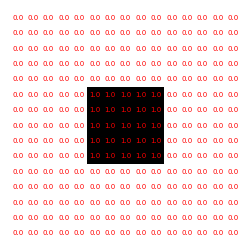

In [17]:
image = np.pad(np.ones((5, 5)), 5, constant_values=0)
implot(image, cmap="binary", show_val=True, font_size=5)

Mean and gaussian filtering

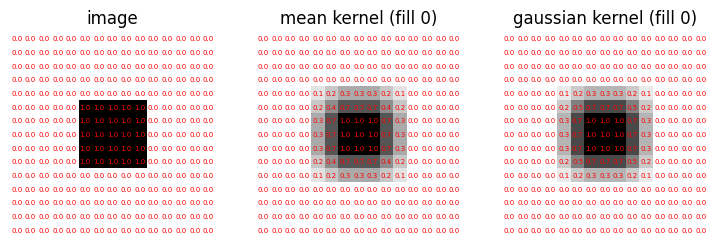

In [18]:
def get_mean_kernel(size: Tuple[int, int] = (3, 3)) -> np.ndarray:
    return np.ones(size) / (size[0] * size[1])


def get_gaussian_kernel(
    size: Tuple[int, int] = (3, 3), center: Tuple[int, int] = (1, 1), sigma: float = 1.2
) -> np.ndarray:
    x, y = np.meshgrid(np.arange(size[1]), np.arange(size[0]))
    gaussian_kernel = np.exp(
        -((x - center[1]) ** 2 + (y - center[0]) ** 2) / (2 * sigma**2)
    )
    gaussian_kernel /= 2 * np.pi * sigma**2
    gaussian_kernel /= np.sum(gaussian_kernel)  # standarize output
    return gaussian_kernel


mean_kernel = get_mean_kernel()
gaussian_kernel = get_gaussian_kernel()

implot(
    [
        image,
        convolve2d(image, mean_kernel, "same"),
        convolve2d(image, gaussian_kernel, "same"),
    ],
    ["image", "mean kernel (fill 0)", "gaussian kernel (fill 0)"],
    cmap="binary",
    show_val=True,
    font_size=5,
    cols=3,
)

On real-live image

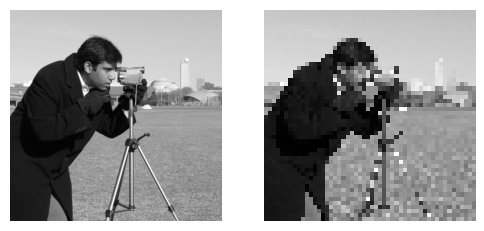

In [19]:
camera = data.camera()
pixelated = camera[::10, ::10]
implot([camera, pixelated], cols=2, cmap="gray")

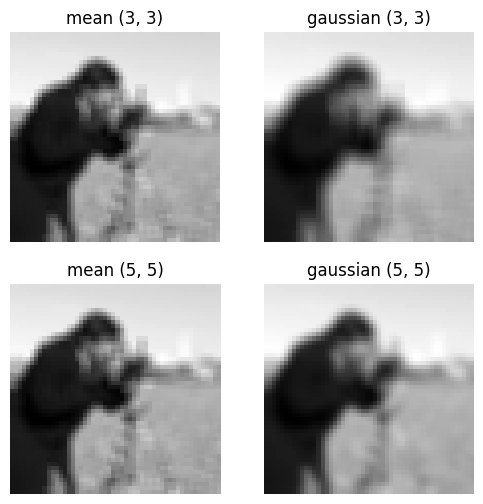

In [20]:
implot(
    [
        cv2.filter2D(pixelated, -1, mean_kernel),
        cv2.filter2D(pixelated, -1, get_mean_kernel(size=(5, 5))),
        cv2.filter2D(pixelated, -1, mean_kernel),
        cv2.filter2D(pixelated, -1, get_gaussian_kernel(size=(5, 5), center=(2, 2))),
    ],
    names=["mean (3, 3)", "gaussian (3, 3)", "mean (5, 5)", "gaussian (5, 5)"],
    cols=2,
    cmap="gray",
)

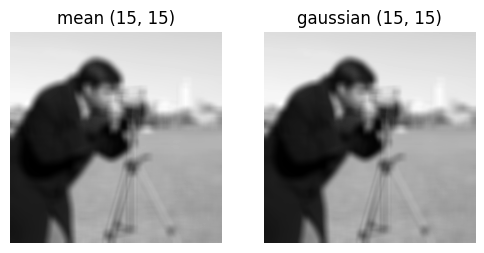

In [21]:
implot(
    [
        cv2.filter2D(camera, -1, get_mean_kernel(size=(21, 21))),
        cv2.filter2D(
            camera, -1, get_gaussian_kernel(size=(21, 21), center=(15, 15), sigma=20)
        ),
    ],
    names=["mean (15, 15)", "gaussian (15, 15)"],
    cols=2,
    cmap="gray",
)

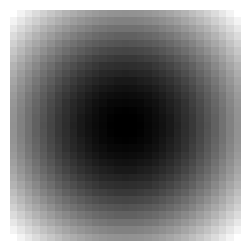

In [22]:
implot(get_gaussian_kernel(size=(31, 31), center=(15, 15), sigma=20), cmap="binary")

In [23]:
imgs = [pixelated, camera, image]

Difference filter

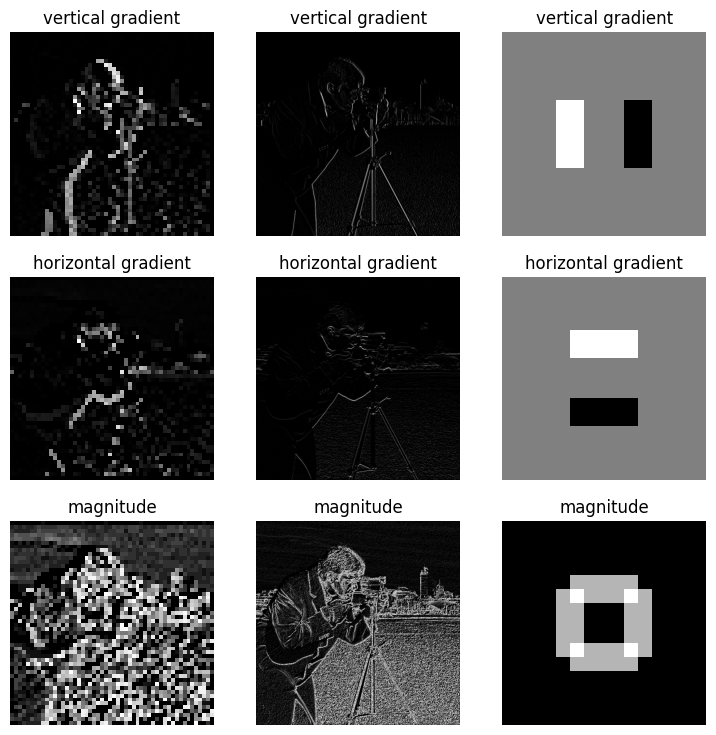

In [24]:
# higher kernel sizes
# kernel_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=np.float32)
# kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float32)

kernel_x = np.array([[-1, 0, 1]], dtype=np.float32)
kernel_y = np.array([[-1], [0], [1]], dtype=np.float32)

apply(imgs, kernel_x=kernel_x, kernel_y=kernel_y, cmap="gray")

# last column shows transformations on earlier "square" image

Sobel filter - a joint Gaussian smoothing plus differentiation operation - more resistant to noise

https://en.wikipedia.org/wiki/Sobel_operator

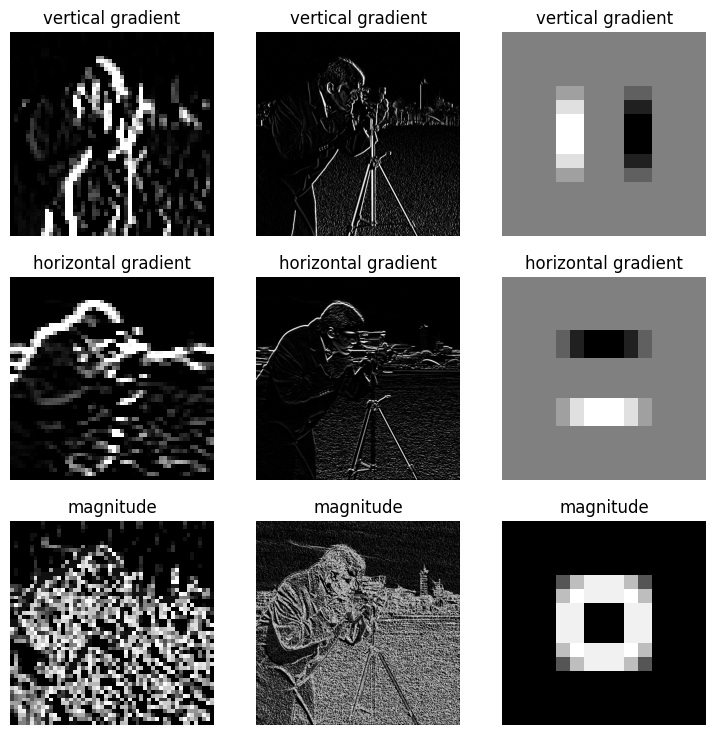

In [25]:
kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)

apply(imgs, kernel_x=kernel_x, kernel_y=kernel_y, cmap="gray")

higher kernel sizes

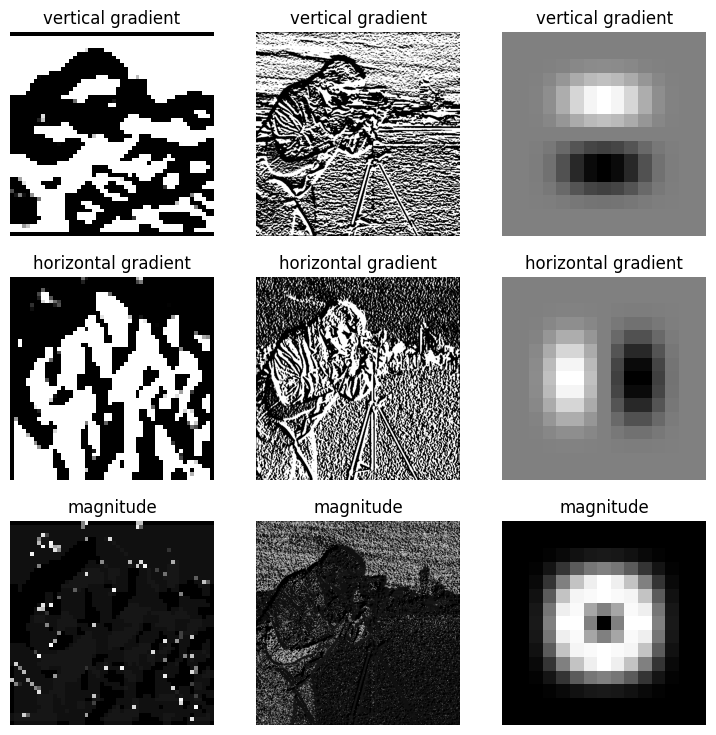

In [26]:
filter_x = lambda img: cv2.Sobel(img, -1, 0, 1, ksize=7)
filter_y = lambda img: cv2.Sobel(img, -1, 1, 0, ksize=7)
filter_all = lambda img: np.sqrt(filter_x(img) ** 2 + filter_y(img) ** 2)

apply(imgs, filter_x=filter_x, filter_y=filter_y, filter_all=filter_all, cmap="gray")

due to some implementation details skimage might perform better in cv2 you need to carefully choose output values

https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.sobel

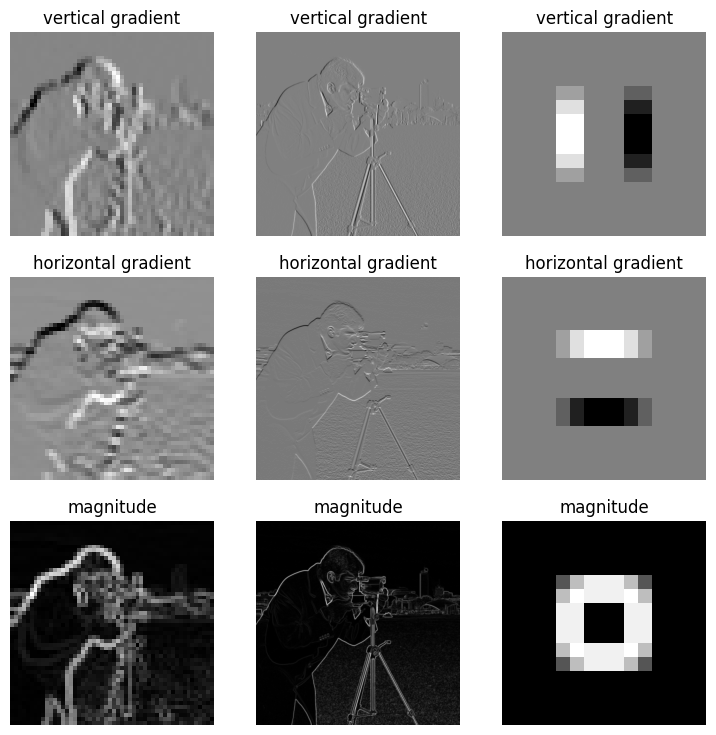

In [27]:
apply(
    imgs,
    filter_x=filters.sobel_v,
    filter_y=filters.sobel_h,
    filter_all=filters.sobel,
    cmap="gray",
)

alternatively Sobel–Feldman filter - it uses kernel (for x) less brutal artefacts, yet rotational symetry is worse

[   [3, 0, -3], 
    [10, 0, -10], 
    [3, 0, -3]  ]

and Sharr filter - it uses kernel (for x) offers better rotational symmetry and is less sensitive to noise compared to the Sobel filter.

[   [47, 0, -47], 
    [162, 0, -162], 
    [47, 0, -47]    ]

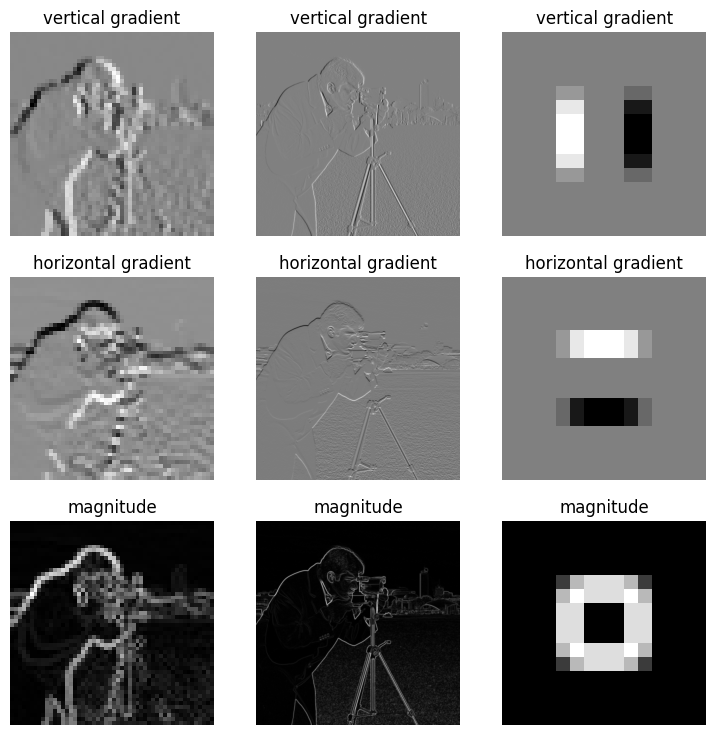

In [28]:
apply(
    imgs,
    filter_x=filters.scharr_v,
    filter_y=filters.scharr_h,
    filter_all=filters.scharr,
    cmap="gray",
)

median filter - will return median of neighborhood's pixel values good for preserving edges

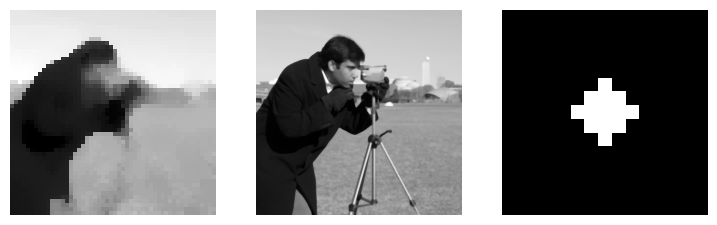

In [29]:
# will create binary (0 or 1) "kernel" of radius 3 that
# will represent disc, values one represents that these pixels we
# want to consider in our median filter
neighborhood = disk(3)

implot(
    [
        filters.rank.median(pixelated, neighborhood),
        filters.rank.median(camera, neighborhood),
        filters.rank.median(image, neighborhood),
    ],
    cols=3,
    cmap="gray",
)

In [30]:
disk(3)

array([[0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0]], dtype=uint8)

Bilateral filter - also well preserves edges

https://en.wikipedia.org/wiki/Bilateral_filter

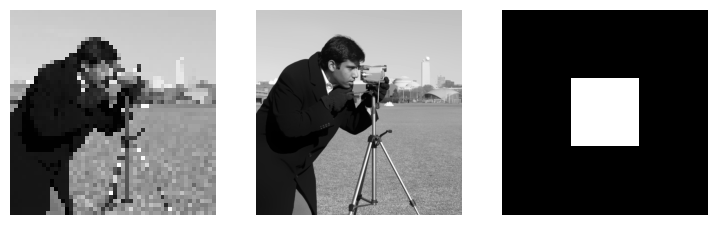

In [31]:
implot(
    [
        filters.rank.mean_bilateral(pixelated, disk(20)),
        filters.rank.mean_bilateral(camera, disk(20)),
        filters.rank.mean_bilateral(image, disk(5)),
    ],
    cols=3,
    figsize=(9, 3),
    cmap="gray",
)

equalization

used mostly for images where obvious seperation between foreground and background occurs or where colors are all dark / light

https://en.wikipedia.org/wiki/Histogram_equalization

https://en.wikipedia.org/wiki/Adaptive_histogram_equalization

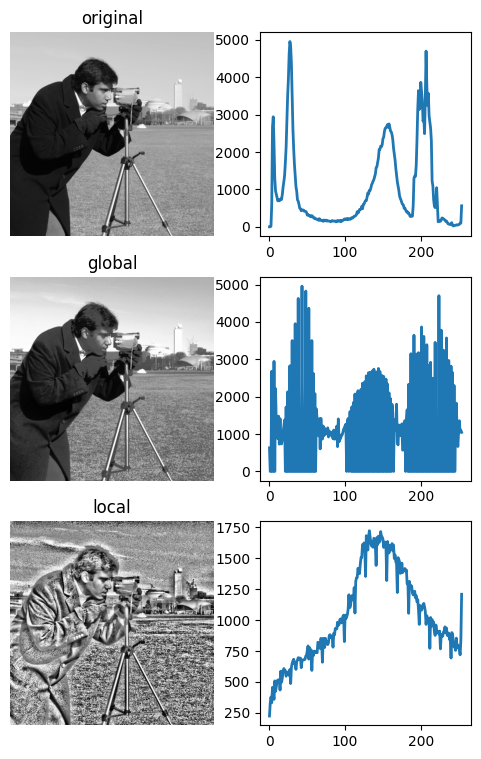

In [32]:
# equalize globally and locally
imgs = [
    camera,
    exposure.equalize_hist(camera) * 255,  # global
    filters.rank.equalize(camera, disk(20)),  # local
]

im_hist_plot(imgs, ["original", "global", "local"], cmap="gray")

Histogram streching

https://www.tutorialspoint.com/dip/histogram_stretching.htm

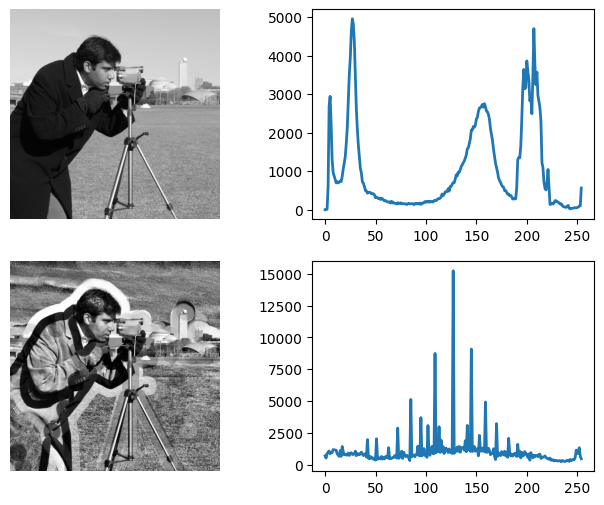

In [33]:
auto = filters.rank.autolevel(camera, disk(20))

im_hist_plot([camera, auto], cmap="gray", figsize=(8, 6))

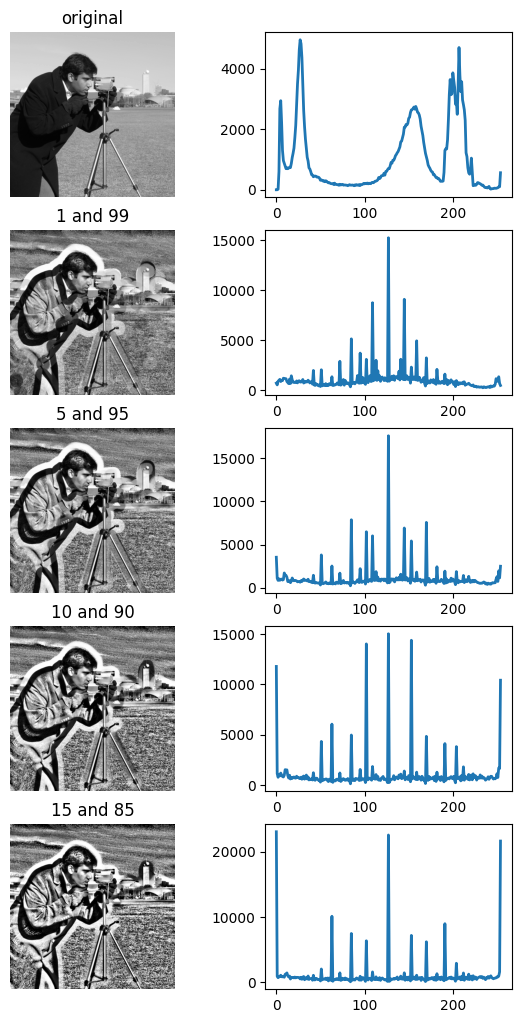

In [34]:
footprint = disk(20)

im_hist_plot(
    [
        camera,
        filters.rank.autolevel(camera, footprint=footprint),
        filters.rank.autolevel_percentile(
            camera, footprint=footprint, p0=0.01, p1=0.99
        ),
        filters.rank.autolevel_percentile(
            camera, footprint=footprint, p0=0.05, p1=0.95
        ),
        filters.rank.autolevel_percentile(camera, footprint=footprint, p0=0.1, p1=0.9),
        filters.rank.autolevel_percentile(
            camera, footprint=footprint, p0=0.15, p1=0.85
        ),
    ],
    names=["original", "1 and 99", "5 and 95", "10 and 90", "15 and 85"],
    figsize=(7, 15),
)

Skimage's engance_contrast filter

replaces each pixel by local minimum if it is closer to local minium than to local maximum, otherwise replaces it by local maximum

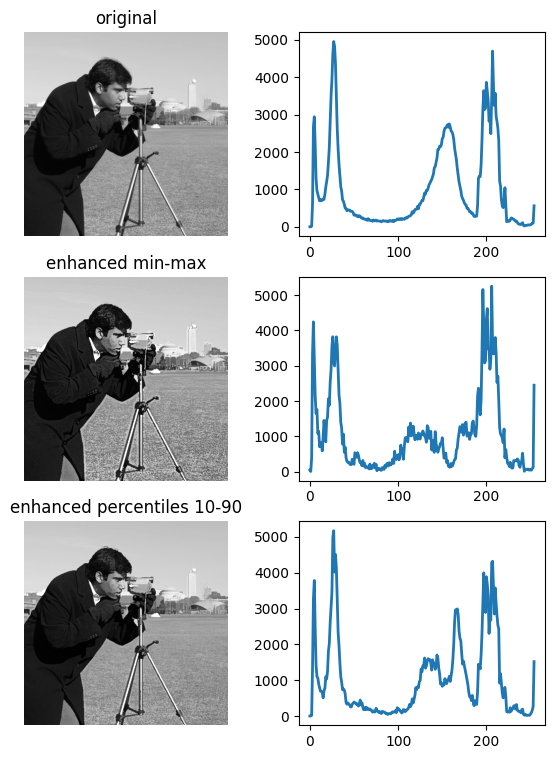

In [35]:
enhanced = filters.rank.enhance_contrast(camera, disk(5))
enganced_percentile = filters.rank.enhance_contrast_percentile(
    camera, disk(5), p0=0.1, p1=0.9
)

im_hist_plot(
    [camera, enhanced, enganced_percentile],
    names=["original", "enhanced min-max", "enhanced percentiles 10-90"],
    cmap="gray",
    figsize=(7, 9),
)

Otsu filtering

https://en.wikipedia.org/wiki/Otsu%27s_method

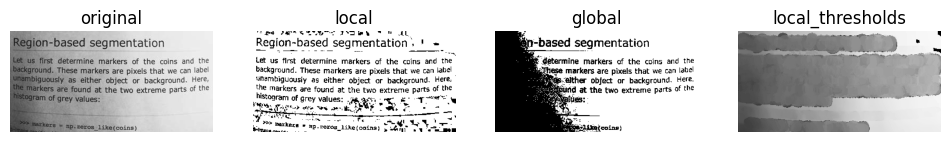

157


In [36]:
from skimage.filters import threshold_otsu

page = data.page()
footprint = disk(10)

# t_loc_otsu holds at each pixel position it's otsu threshold
t_loc_otsu = filters.rank.otsu(page, footprint)
loc_otsu = page >= t_loc_otsu

# t_glob_otsu is a scalar - global otsu threshold
t_glob_otsu = threshold_otsu(page)
glob_otsu = page >= t_glob_otsu

implot(
    [page, loc_otsu, glob_otsu, t_loc_otsu],
    cols=4,
    cmap="gray",
    names=["original", "local", "global", "local_thresholds"],
)
print(t_glob_otsu)

Erosion and delatation

https://towardsdatascience.com/understanding-morphological-image-processing-and-its-operations-7bcf1ed11756

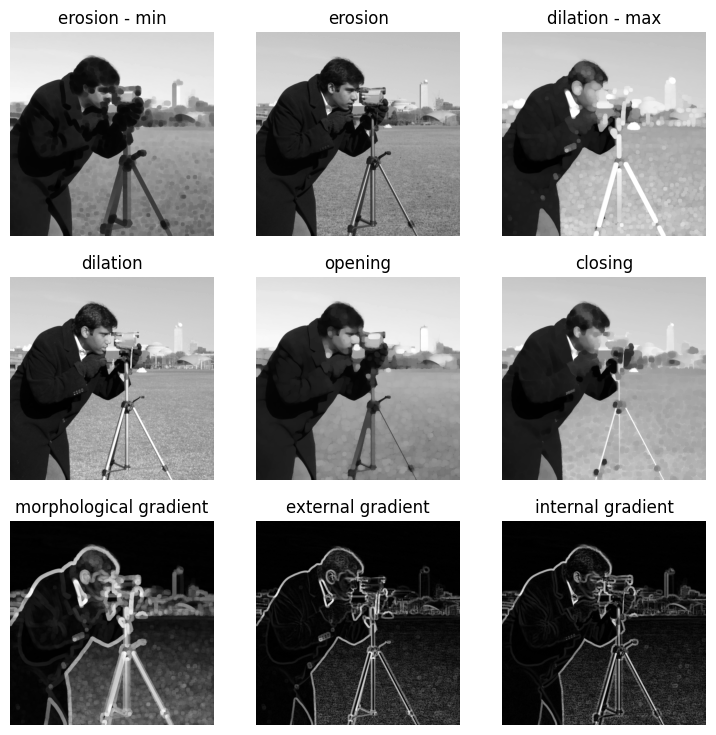

In [37]:
A = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])

binary_camera = camera
# that erosion will return min value of neighborhood
erosion_ = filters.rank.minimum(camera, disk(5))
my_erosion = erosion(camera, A)
# that dilation will return max value of neighborhood
dilation_ = filters.rank.maximum(camera, disk(5))
my_dilation = dilation(camera, A)

implot(
    [
        # erosion
        erosion_,
        my_erosion,
        # dilation
        dilation_,
        my_dilation,
        # opening
        filters.rank.maximum(erosion_, disk(5)),
        # closing
        filters.rank.minimum(dilation_, disk(5)),
        # morphological gradient
        filters.rank.gradient(camera, disk(5)),
        # external gradient
        dilation_ - camera,
        # internal gradient
        camera - erosion_,
    ],
    names=[
        "erosion - min",
        "erosion",
        "dilation - max",
        "dilation",
        "opening",
        "closing",
        "morphological gradient",
        "external gradient",
        "internal gradient",
    ],
    cols=3,
    cmap="gray",
)

Entropy filters

https://towardsdatascience.com/image-processing-with-python-working-with-entropy-b05e9c84fc36

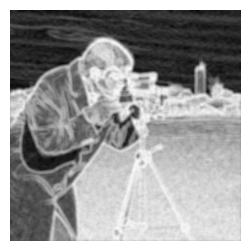

In [38]:
implot(filters.rank.entropy(camera, disk(5)), cmap="gray")

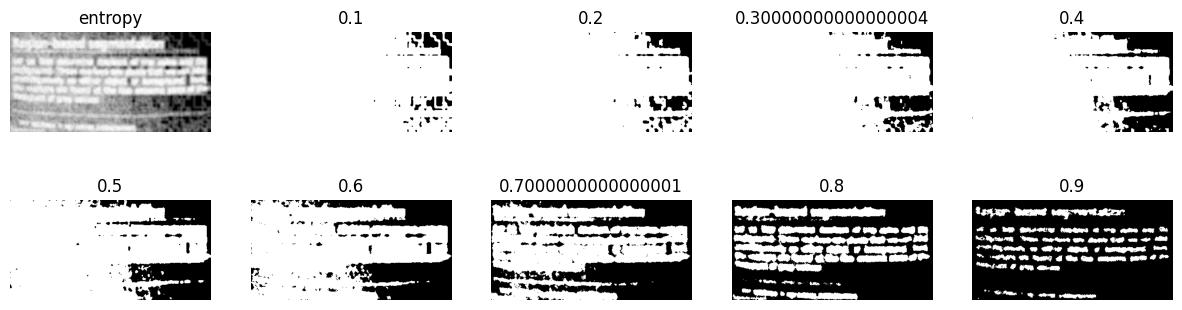

In [39]:
def threshold_checker(image):
    thresholds = np.arange(0.1, 1, 0.1)
    entropy_image = filters.rank.entropy(image, disk(4))
    scaled_entropy = entropy_image / entropy_image.max()
    imgs = [scaled_entropy] + [scaled_entropy > threshold for threshold in thresholds]
    implot(
        imgs,
        ["entropy"] + [str(t) for t in thresholds],
        cols=5,
        cmap="gray",
        figsize=(15, 4),
    )


threshold_checker(page)

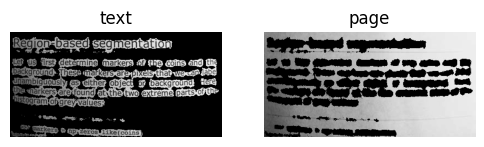

In [40]:
entropy = filters.rank.entropy(page, disk(4))
entropy = entropy / entropy.max()
mask_text = entropy > 0.8
mask_page = entropy <= 0.8

implot([page * mask_text, page * mask_page], ["text", "page"], cols=2, cmap="gray")